In [1]:
% matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import sys
import random
from glob import glob

from multiprocessing import Pool
import numpy as np
import pandas as pd

from tqdm import tqdm
import scipy.misc
from skimage.morphology import label
import skimage

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set some parameters
IMG_CHANNELS = 3
DATA = {
    'TRAIN': '../data/train/',
    'TEST': '../data/test/'
}

train_paths = glob(os.path.join(DATA['TRAIN'], '*'))
test_paths = glob(os.path.join(DATA['TEST'], '*'))

MASK_POSTFIX = 'mask_ibn'
seed = 42
P_THRESHOLD = .5
BATCH_SIZE = 16
SIDE = 256
STEP = SIDE // 4

# Amount of categories predicted per pixels.
nb_classes = 1

np.random.seed = seed

SPLIT = .9

In [4]:
def load(path, test_mode=False):
    im = scipy.misc.imread(os.path.join(path, 'images', os.path.basename(path) + '.png'))[..., :IMG_CHANNELS]
    
    if im.std(-1).sum() > 10:
        im = (im - im.min((0, 1))) / (im.max((0, 1)) - im.min((0, 1)))
        im = np.abs(im.astype(np.float).mean(-1) - 1.)
    else:
        im = im[..., 0].astype(np.float)
        im = (im - im.min()) / (im.max() - im.min())
    
    if test_mode:
        return im
    
    return np.dstack([
        im,
        np.load(os.path.join(path, MASK_POSTFIX + '.npy')),
    ])

In [5]:
def preprocess_val(patch):
    return np.dstack([
        scipy.ndimage.zoom(patch[..., :-1].mean(-1), (SIDE / patch.shape[0], SIDE / patch.shape[1])),
        scipy.ndimage.zoom(patch[..., -1], (SIDE / patch.shape[0], SIDE / patch.shape[1]), order=0)
    ])

In [6]:
def scale_img_canals(an_img):
    for i in range(IMG_CHANNELS):
        canal = an_img[:,:,i]
        canal = canal - canal.min()
        canalmax = canal.max()
        if canalmax > 0:
            canal = (canal * 255 / canalmax).astype(int)
        an_img[:,:,i] = canal
    return an_img

In [7]:
def preprocess(patch):
    scale = np.random.uniform(.5, 1.1, size=2)
    
    if np.random.randint(2):
        patch = np.flip(patch, 0)
    if np.random.randint(2):
        patch = np.flip(patch, 1)
    if np.random.randint(2):
        patch = np.rot90(patch, k=np.random.randint(3) + 1)
    
    if not np.random.randint(3):
        patch = np.concatenate([np.flip(patch, 0), patch, np.flip(patch, 0)])
    if not np.random.randint(3):
        patch = np.concatenate([np.flip(patch, 1), patch, np.flip(patch, 1)], 1)
    
#     if np.random.randint(4):
#         rotate = np.random.uniform(-40, 40)
#         patch = np.dstack([
#             scipy.ndimage.rotate(patch[..., 0], rotate),
#             scipy.ndimage.rotate(patch[..., -1:], rotate, order=0)
#         ])
#         patch = skimage.transform.rotate(patch, rotate, mode='constant', preserve_range=True)
    
    window = np.clip(SIDE * scale, 0, min(patch.shape[:-1]))
    if np.count_nonzero(patch[..., -1]):
        coords = np.array(np.where(patch[..., -1]))
        cmin, cmax = coords.min(1) - window, coords.max(1)
        point = np.array([
            np.random.randint(cmin[0], cmax[0]),
            np.random.randint(cmin[1], cmax[1])
        ])
    else:
        point = np.array([
            np.random.randint(0, patch.shape[0] - window[0] + 1),
            np.random.randint(0, patch.shape[1] - window[1] + 1)
        ]) 
    point = np.clip(point, 0, np.array(patch.shape[:-1]) - window).astype(np.int)

    patch = patch[
        point[0]: point[0] + int(window[0]), 
        point[1]: point[1] + int(window[1])
    ]
    
    return np.dstack([
        scipy.ndimage.zoom(patch[..., 0],  (SIDE / patch.shape[0], SIDE / patch.shape[1])),
        scipy.ndimage.zoom(patch[..., -1],  (SIDE / patch.shape[0], SIDE / patch.shape[1]), order=0)
    ])

In [8]:
def generator(paths, preprocess, batch_size=BATCH_SIZE, train_mode=False):
    while True:
        if train_mode:
            np.random.shuffle(paths)
            
        for i in range(len(paths) // batch_size + 1):
#             with Pool(4) as pool:
#                 processed = pool.map(load, batch)
#             with Pool(4) as pool:
#                 processed = pool.map(preprocess, processed)
            batch = paths[i * batch_size: (i + 1) * batch_size]
            processed = np.zeros((batch_size, SIDE, SIDE, 2))
            for j, path in enumerate(batch):
                im = load(path)
                processed[j] = preprocess(im)

            yield np.expand_dims(processed[..., 0], -1) / 255., np.expand_dims(processed[..., -1], -1)

In [9]:
train_gen = generator(train_paths, preprocess, batch_size=BATCH_SIZE, train_mode=False)
a = next(train_gen)

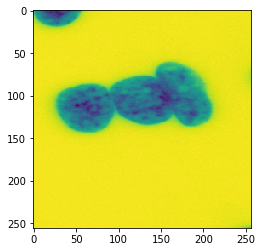

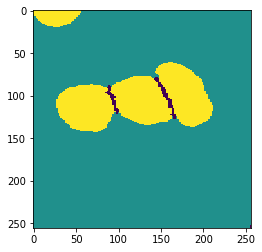

In [10]:
i = 4
plt.imshow(np.abs(a[0][i,...,0] - 1))
plt.show()
plt.imshow(a[1][i, ...,0])

In [11]:
from keras import backend as K


K.set_image_data_format('channels_last')  # TF dimension ordering in this code

# 
# 
smooth = 1.
# 
# 

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(K.cast(K.greater(y_true_f, 0), 'float32')) + K.sum(y_pred_f) + smooth)


def binary_crossentropy(target, output, from_logits=False):
    """Binary crossentropy between an output tensor and a target tensor.
    # Arguments
        target: A tensor with the same shape as `output`.
        output: A tensor.
        from_logits: Whether `output` is expected to be a logits tensor.
            By default, we consider that `output`
            encodes a probability distribution.
    # Returns
        A tensor.
    """
    # Note: tf.nn.sigmoid_cross_entropy_with_logits
    # expects logits, Keras expects probabilities.
    if not from_logits:
        # transform back to logits
        _epsilon = K._to_tensor(epsilon(), output.dtype.base_dtype)
        output = tf.clip_by_value(output, _epsilon, 1 - _epsilon)
        output = tf.log(output / (1 - output))

    return tf.nn.sigmoid_cross_entropy_with_logits(
        labels=target,
        logits=output
    )


def binary_crossentropy(y_true, y_pred):
    return K.mean(K.binary_crossentropy(K.cast(K.greater(y_true, 0), 'float32'), y_pred))

def dice_coef_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + 1 - dice_coef(y_true, y_pred)

# def dice_coef_loss(y_true, y_pred):
#     return binary_crossentropy(y_true, y_pred) - K.log(dice_coef(y_true, y_pred))
#     return -dice_coef(y_true, y_pred)

Using TensorFlow backend.


In [12]:
# std_paths = list()
# for n, path in tqdm(enumerate(train_paths), total=len(train_paths)):
#     img = imread(os.path.join(path, 'images', os.path.basename(path) + '.png'))[..., :IMG_CHANNELS]
#     mask = list()
#     for mask_file in next(os.walk(path + '/masks/'))[2]:
#         mask.append(imread(path + '/masks/' + mask_file))
#     std_paths.append((path, img.std(-1).sum(), len(mask)))
#     mask = np.array(mask).max(0)
#     np.save(path + '/mask', mask)


# std_paths = list()
# for n, path in tqdm(enumerate(test_paths), total=len(test_paths)):
#     img = scipy.misc.imread(os.path.join(path, 'images', os.path.basename(path) + '.png'))[..., :IMG_CHANNELS]
#     std_paths.append((path, img.std(-1).sum()))


# for n, path in tqdm(enumerate(train_paths), total=len(train_paths)):
#     mask = list()
#     for mask_file in next(os.walk(path + '/masks/'))[2]:
#         im = scipy.misc.imread(path + '/masks/' + mask_file)
#         im = scipy.ndimage.distance_transform_edt(im)
#         im[im == 0] = 1e+7
#         mask.append(im)
#     mask = np.array(mask).min(0)
#     mask[mask == 1e+7] = 0
#     mask[scipy.ndimage.binary_dilation((mask == 1), iterations=2) & np.logical_not(mask >= 1.1)] = -1
#     mask[mask > 0] = 1
#     np.save(path + '/mask_edt_bn', mask)


# for n, path in tqdm(enumerate(train_paths), total=len(train_paths)):
#     masks = list()
#     for mask_file in next(os.walk(path + '/masks/'))[2]:
#         masks.append(scipy.misc.imread(path + '/masks/' + mask_file) > 0)
#     mask = np.array(masks).max(0)
#     imask = mask.copy().astype(np.float)
#     borders = np.zeros(np.array(imask.shape) - 4, dtype=np.bool_)
#     borders = np.pad(borders, pad_width=2, mode='constant', constant_values=1)
#     for im in masks:
#         tmp = mask.copy()
#         tmp_borders = borders.copy()
#         tmp[im] = False
#         tmp_borders[im] = False
#         dilated_im = scipy.ndimage.binary_dilation(im)
#         intersection = (
#             (scipy.ndimage.binary_dilation(tmp) & dilated_im) |
#             (tmp_borders & scipy.ndimage.binary_dilation(dilated_im))
#         )
#         imask[intersection] = -1.5
#     np.save(path + '/mask_ibn', imask)


# glob_areas = list()
# for n, path in tqdm(enumerate(train_paths), total=len(train_paths)):

#     masks = list()
#     for mask_file in next(os.walk(path + '/masks/'))[2]:
#         masks.append(scipy.misc.imread(path + '/masks/' + mask_file) > 0)

#     mask = np.array(masks).max(0)
#     imask = mask.copy().astype(np.float)
#     borders = np.zeros(np.array(imask.shape) - 4, dtype=np.bool_)
#     borders = np.pad(borders, pad_width=2, mode='constant', constant_values=1)
    
#     areas = list()
#     for im in masks:
#         areas.append(im.sum())
        
#     mean = np.median(areas)
#     for i, im in enumerate(masks):
#         tmp = mask.copy()
#         tmp[im] = False
#         tmp_borders = borders.copy()
#         tmp_borders[im] = False
#         dilated_im = scipy.ndimage.binary_dilation(im)
#         intersection = (
#             (scipy.ndimage.binary_dilation(tmp) & dilated_im) |
#             (tmp_borders & scipy.ndimage.binary_dilation(dilated_im))
#         )

#         weight = (mean / intersection.sum()) ** (2 / 3)
#         imask[intersection] = -1 * np.log(weight)

#     for i, im in enumerate(masks):
#         residual_im = im & (imask > 0)
#         imask[residual_im] = 1.#np.log(mean / residual_im.sum())

#     np.save(path + '/mask_ibn_rel', imask)
#     glob_areas.append(areas)


sizes_train = dict()
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, path in tqdm(enumerate(train_paths), total=len(train_paths)):
    img = scipy.misc.imread(os.path.join(path, 'images', os.path.basename(path) + '.png'))[..., :IMG_CHANNELS]
    sizes_train[path] = ([img.shape[0], img.shape[1]])
    

sizes_test = dict()
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, path in tqdm(enumerate(test_paths), total=len(test_paths)):
    img = scipy.misc.imread(os.path.join(path, 'images', os.path.basename(path) + '.png'))[..., :IMG_CHANNELS]
    sizes_test[path] = ([img.shape[0], img.shape[1]])

Getting and resizing test images ... 


100%|██████████| 670/670 [00:02<00:00, 228.42it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:00<00:00, 192.41it/s]


In [13]:
import pickle

# pickle.dump(std_paths, open('../data/test_std_paths.pkl', 'wb'))
std_paths = pickle.load(open('../data/std_paths.pkl', 'rb'))
test_std_paths = pickle.load(open('../data/test_std_paths.pkl', 'rb'))

In [14]:
paths = [path[0] for path in std_paths]
rs = np.random.RandomState(seed=12)
rs.shuffle(paths)

In [15]:
import sys
sys.path.append('..')
from models import UNet
from models import elu_UNet


model = elu_UNet.get_unet((SIDE, SIDE, 1), 16, optimizer='adam', #sgd(nesterov=True, momentum=.9, decay=1e-5)
                          loss=dice_coef_loss, metrics=[binary_crossentropy, dice_coef])

In [16]:
def inverse_rle(rle):
    rle_ = list(map(int, rle.split(' ')))
    inv = list()
    for idx in range(len(rle_) // 2):
        inv.extend(list(range(rle_[2 * idx], rle_[2 * idx] + rle_[2 * idx + 1])))
    return inv

from skimage.morphology import closing, opening, disk
def clean_img(x):
    return opening(closing(x, disk(1)), disk(3))

In [17]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=.5):
    lab_img = label(x > cutoff)
#     lab_img_dilated2 = label(scipy.ndimage.binary_dilation(x > cutoff, iterations=2))
#     lab_img_dilated1 = label(scipy.ndimage.binary_dilation(x > cutoff, iterations=1))
    for colour in range(1, lab_img.max() + 1):
#         inter = lab_img[lab_img_dilated2 == lab_img_dilated2[lab_img == colour][0]]
#         inter = inter[inter != 0]
#         if len(np.unique(inter)) == 1:
#             yield rle_encoding(scipy.ndimage.binary_dilation(lab_img == colour, iterations=2))
#             continue
#         inter = lab_img[lab_img_dilated1 == lab_img_dilated1[lab_img == colour][0]]
#         inter = inter[inter != 0]
#         if len(np.unique(inter)) == 1:
#             yield rle_encoding(scipy.ndimage.binary_dilation(lab_img == colour, iterations=1))
#             continue
        yield rle_encoding(lab_img == colour)

In [18]:
from itertools import product


def preprocess_test(patch):
    patch = scipy.ndimage.zoom(
        patch, 
        (
            max(patch.shape[0], SIDE) / patch.shape[0], 
            max(patch.shape[1], SIDE) / patch.shape[1]
        )
    )
    shape = patch.shape
    patch = np.concatenate([np.flip(patch, 0), patch, np.flip(patch, 0)])
    patch = np.concatenate([np.flip(patch, 1), patch, np.flip(patch, 1)], 1)
    
    points = [i for i in range(0, shape[0] + STEP, STEP)]
    points = product(points, [i for i in range(0, shape[1] + STEP, STEP)])
    points = np.array(list(points)) - SIDE // 2 + np.array(shape)
    
    patches = list()
    for point in points:
        patches.append((patch[
            point[0]: point[0] + SIDE,
            point[1]: point[1] + SIDE,
        ] / 255., point + SIDE // 2 - np.array(shape), shape))
    return patches


def generator_test(paths, batch_size=BATCH_SIZE, train_mode=False):
    while True:
        if train_mode:
            np.random.shuffle(paths)
            
        for i in range(len(paths) // batch_size + 1):
            batch = paths[i * batch_size: (i + 1) * batch_size]
            processed = list()
            for j, path in enumerate(batch):
                im = load(path, test_mode=True)
                processed += (preprocess_test(im), path)

            yield processed

In [19]:
MODEL_PREFIX = 'elu24_dice_unet_border_1.5_val_'

In [20]:
def preprocess_test(patch):
    return scipy.ndimage.zoom(patch, (SIDE / patch.shape[0], SIDE / patch.shape[1]))


def generator_test(paths, batch_size=BATCH_SIZE, train_mode=False):
    while True:
        if train_mode:
            np.random.shuffle(paths)
            
        for i in range(len(paths) // batch_size + 1):
            batch = paths[i * batch_size: (i + 1) * batch_size]
#             with Pool(4) as pool:
#                 processed = pool.map(load, batch)
            processed = np.zeros((batch_size, SIDE, SIDE))
            for j, path in enumerate(batch):
                im = load(path, test_mode=True)
                processed[j] = preprocess_test(im)

            yield np.expand_dims(processed, -1) / 255.

In [30]:
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.optimizers import sgd


inter = len(paths) - int(SPLIT * len(paths))
val_evals = list()
for i in range(10):
    train_paths = paths[:i * inter] + paths[(i + 1) * inter:]
    val_paths = paths[i * inter: (i + 1) * inter]

    test_paths = [path[0] for path in test_std_paths]

    callbacks = [
        TensorBoard(log_dir='../data/logs'),
        ModelCheckpoint(
            verbose=True,
            filepath='../data/' + MODEL_PREFIX + str(i),
            save_best_only=True
        )
    ]

    train_gen = generator(train_paths, preprocess, batch_size=BATCH_SIZE, train_mode=True)
    val_gen = generator(val_paths, preprocess_val, batch_size=BATCH_SIZE, train_mode=False)

    model = elu_UNet.get_unet(SIDE, SIDE, filters_init=24, optimizer='adam', #sgd(nesterov=True, momentum=.9, decay=1e-5)
                              loss=dice_coef_loss, metrics=[binary_crossentropy, dice_coef])
    model.fit_generator(
        generator=train_gen,
        steps_per_epoch=max(len(train_paths) // BATCH_SIZE + 1, 10), 
        epochs=50, 
        callbacks=callbacks, 
        validation_data=val_gen, 
        validation_steps=len(val_paths) // BATCH_SIZE + 1, 
    )
    
    model.load_weights(os.path.join('..', 'data', MODEL_PREFIX + str(i)))
    
    val_paths = paths[i * inter: (i + 1) * inter]
    val_gen = generator_test(val_paths, batch_size=1, train_mode=False)
    val = [next(val_gen) for i in range(len(val_paths))]
    val = np.concatenate(val, 0)
    val = val[:len(val_paths)]

    p = model.predict(val)
    p1 = model.predict(np.flip(val, 1))
    p2 = model.predict(np.flip(val, 2))
    p3 = model.predict(np.flip(np.flip(val, 1), 2))

    pred = (
        np.mean(
            np.stack([
                p, 
                np.flip(p1, 1), 
                np.flip(p2, 2), 
                np.flip(np.flip(p3, 1), 2)
            ], -1), 
            -1
        )
    )

    # Create list of upsampled test masks
    preds_val_upsampled = list()
    for v_idx in range(len(pred)):
        preds_val_upsampled.append(
            skimage.transform.resize(
                np.squeeze(pred[v_idx]), 
                sizes_train[val_paths[v_idx]],
                mode='constant', 
                preserve_range=True
            )
        )


    new_val_ids = []
    rles = []
    for n, path in tqdm(enumerate(val_paths)):
        rle = list(prob_to_rles(preds_val_upsampled[n], cutoff=P_THRESHOLD))
        rles.extend(rle)
        new_val_ids.extend([os.path.basename(path)] * len(rle))


    val_df = pd.DataFrame()
    val_df['ImageId'] = new_val_ids
    val_df['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
    val_ids = pd.Series(val_paths).apply(lambda x: os.path.basename(x))
    val_eval = pd.DataFrame(val_ids, columns=['ImageId'])


    train_labels = pd.read_csv('../data/stage1_train_labels.csv')
    tl_rles = train_labels[train_labels.ImageId.isin(val_ids)]

    for t in np.arange(.5, 1, .05):
        val_eval["%.2f"%t] = 0.

    for vidx in tqdm(val_ids.index):
        for t in np.arange(.5, 1, .05):
            gtrue_rles = tl_rles.query('ImageId=="{ImageId}"'.format(ImageId=val_ids[vidx]))['EncodedPixels']
            pred_rles = val_df.query('ImageId=="{ImageId}"'.format(ImageId=val_ids[vidx]))['EncodedPixels']
            pred_rles = pred_rles.values.tolist()
            FN = np.ones_like(gtrue_rles)
            TP = 0

            for gidx, gtrue_ in enumerate(gtrue_rles):
                gtrue_ = set(inverse_rle(gtrue_))
                for idx, pred_ in enumerate(pred_rles):
                    pred_ = set(inverse_rle(pred_))
                    IoU = len(pred_.intersection(gtrue_)) / len(pred_.union(gtrue_))
                    if IoU > t:
                        TP += 1
                        pred_rles.pop(idx)
                        FN[gidx] = 0
                        continue

            val_eval.loc[val_eval.ImageId == val_ids[vidx], "%.2f"%t] = TP / (TP + len(pred_rles) + FN.sum())

    val_eval['tmean'] = val_eval[["%.2f"%t for t in np.arange(.5, 1, .05)]].mean(1)
    print(val_eval.tmean.mean())
    print(val_eval[["%.2f"%t for t in np.arange(.5, 1, .05)]].mean())
    val_evals.append(val_eval)

    model.save_weights('../data/' + MODEL_PREFIX + str(i) + '_score_' + "%.3f" % val_eval.tmean.mean())

Epoch 1/50


ValueError: Error when checking input: expected input_3 to have shape (256, 256, 3) but got array with shape (256, 256, 1)

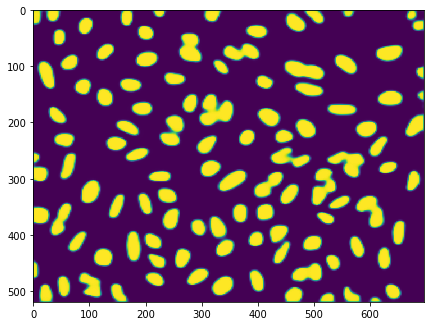

In [149]:
plt.figure(figsize=(7, 7))
plt.imshow(preds_val_upsampled[i])

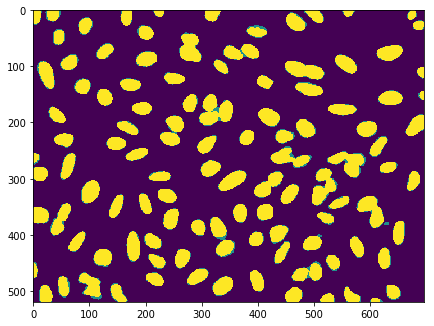

In [155]:
plt.figure(figsize=(7, 7))
plt.imshow((np.load(os.path.join(val_paths[i], 'mask.npy')) * 2 / 255) + (preds_val_upsampled[i] > .5))

In [21]:
# MIT License
# Copyright (c) 2017 Vooban Inc.
# Coded by: Guillaume Chevalier
# Source to original code and license:
#     https://github.com/Vooban/Smoothly-Blend-Image-Patches
#     https://github.com/Vooban/Smoothly-Blend-Image-Patches/blob/master/LICENSE


"""Do smooth predictions on an image from tiled prediction patches."""


import numpy as np
import scipy.signal
from tqdm import tqdm

import gc


def _spline_window(window_size, power=2):
    """
    Squared spline (power=2) window function:
    https://www.wolframalpha.com/input/?i=y%3Dx**2,+y%3D-(x-2)**2+%2B2,+y%3D(x-4)**2,+from+y+%3D+0+to+2
    """
    intersection = int(window_size/4)
    wind_outer = (abs(2*(scipy.signal.triang(window_size))) ** power)/2
    wind_outer[intersection:-intersection] = 0

    wind_inner = 1 - (abs(2*(scipy.signal.triang(window_size) - 1)) ** power)/2
    wind_inner[:intersection] = 0
    wind_inner[-intersection:] = 0

    wind = wind_inner + wind_outer
    wind = wind / np.average(wind)
    return wind


cached_2d_windows = dict()
def _window_2D(window_size, power=2):
    """
    Make a 1D window function, then infer and return a 2D window function.
    Done with an augmentation, and self multiplication with its transpose.
    Could be generalized to more dimensions.
    """
    # Memoization
    global cached_2d_windows
    key = "{}_{}".format(window_size, power)
    if key in cached_2d_windows:
        wind = cached_2d_windows[key]
    else:
        wind = _spline_window(window_size, power)
        wind = np.expand_dims(np.expand_dims(wind, 3), 3)
        wind = wind * wind.transpose(1, 0, 2)
        if PLOT_PROGRESS:
            # For demo purpose, let's look once at the window:
            plt.imshow(wind[:, :, 0], cmap="viridis")
            plt.title("2D Windowing Function for a Smooth Blending of "
                      "Overlapping Patches")
            plt.show()
        cached_2d_windows[key] = wind
    return wind


def _pad_img(img, window_size, subdivisions, PLOT_PROGRESS=False):
    """
    Add borders to img for a "valid" border pattern according to "window_size" and
    "subdivisions".
    Image is an np array of shape (x, y, nb_channels).
    """
    aug = int(round(window_size * (1 - 1.0 / subdivisions)))
    more_borders = ((aug, aug), (aug, aug), (0, 0))
    ret = np.pad(img, pad_width=more_borders, mode='reflect')
    # gc.collect()

    if PLOT_PROGRESS:
        # For demo purpose, let's look once at the window:
        plt.imshow(np.squeeze(ret))
        plt.title("Padded Image for Using Tiled Prediction Patches\n"
                  "(notice the reflection effect on the padded borders)")
        plt.show()
    return ret


def _unpad_img(padded_img, window_size, subdivisions):
    """
    Undo what's done in the `_pad_img` function.
    Image is an np array of shape (x, y, nb_channels).
    """
    aug = int(round(window_size * (1 - 1.0/subdivisions)))
    ret = padded_img[
        aug:-aug,
        aug:-aug,
        :
    ]
    # gc.collect()
    return ret


def _rotate_mirror_do(im):
    """
    Duplicate an np array (image) of shape (x, y, nb_channels) 8 times, in order
    to have all the possible rotations and mirrors of that image that fits the
    possible 90 degrees rotations.

    It is the D_4 (D4) Dihedral group:
    https://en.wikipedia.org/wiki/Dihedral_group
    """
    mirrs = []
    mirrs.append(np.array(im))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=1))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=2))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=3))
    im = np.array(im)[:, ::-1]
    mirrs.append(np.array(im))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=1))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=2))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=3))
    return mirrs


def _rotate_mirror_undo(im_mirrs):
    """
    merges a list of 8 np arrays (images) of shape (x, y, nb_channels) generated
    from the `_rotate_mirror_do` function. Each images might have changed and
    merging them implies to rotated them back in order and average things out.

    It is the D_4 (D4) Dihedral group:
    https://en.wikipedia.org/wiki/Dihedral_group
    """
    origs = []
    origs.append(np.array(im_mirrs[0]))
    origs.append(np.rot90(np.array(im_mirrs[1]), axes=(0, 1), k=3))
    origs.append(np.rot90(np.array(im_mirrs[2]), axes=(0, 1), k=2))
    origs.append(np.rot90(np.array(im_mirrs[3]), axes=(0, 1), k=1))
    origs.append(np.array(im_mirrs[4])[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[5]), axes=(0, 1), k=3)[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[6]), axes=(0, 1), k=2)[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[7]), axes=(0, 1), k=1)[:, ::-1])
    return np.mean(origs, axis=0)


def _windowed_subdivs(padded_img, window_size, subdivisions, nb_classes, pred_func):
    """
    Create tiled overlapping patches.

    Returns:
        5D numpy array of shape = (
            nb_patches_along_X,
            nb_patches_along_Y,
            patches_resolution_along_X,
            patches_resolution_along_Y,
            nb_output_channels
        )

    Note:
        patches_resolution_along_X == patches_resolution_along_Y == window_size
    """
    WINDOW_SPLINE_2D = _window_2D(window_size=window_size, power=2)

    step = int(window_size / subdivisions)
    subdivs = []

    for i in range(0, padded_img.shape[0] - window_size + 1, step):
        subdivs.append([])
        for j in range(0, padded_img.shape[1] - window_size + 1, step):
            patch = padded_img[i: i + window_size, j: j + window_size, :]
            subdivs[-1].append(patch)

    # Here, `gc.collect()` clears RAM between operations.
    # It should run faster if they are removed, if enough memory is available.
    gc.collect()
    subdivs = np.array(subdivs)
    gc.collect()
    a, b, c, d, e = subdivs.shape
    subdivs = subdivs.reshape(a * b, c, d, e)
    gc.collect()

    print(subdivs.shape)
    subdivs = pred_func(subdivs)
    gc.collect()
    subdivs = np.array([patch * WINDOW_SPLINE_2D for patch in subdivs])
    gc.collect()

    # Such 5D array:
    subdivs = subdivs.reshape(a, b, c, d, nb_classes)
    gc.collect()

    return subdivs


def _recreate_from_subdivs(subdivs, window_size, subdivisions, padded_out_shape):
    """
    Merge tiled overlapping patches smoothly.
    """
    step = int(window_size / subdivisions)
    y = np.zeros(padded_out_shape)

    for a, i in enumerate(range(0, padded_out_shape[0] - window_size + 1, step)):
        for b, j in enumerate(range(0, padded_out_shape[1] - window_size + 1, step)):
            windowed_patch = subdivs[a, b]
            y[i: i + window_size, j: j + window_size] = y[i: i + window_size, j: j + window_size] + windowed_patch
    return y / (subdivisions ** 2)


def predict_img_with_smooth_windowing(input_img, window_size, subdivisions, 
                                      nb_classes, pred_func, PLOT_PROGRESS=False):
    """
    Apply the `pred_func` function to square patches of the image, and overlap
    the predictions to merge them smoothly.

    See 6th, 7th and 8th idea here:
    http://blog.kaggle.com/2017/05/09/dstl-satellite-imagery-competition-3rd-place-winners-interview-vladimir-sergey/
    """
    pad = _pad_img(input_img, window_size, subdivisions, PLOT_PROGRESS=PLOT_PROGRESS)
    pads = _rotate_mirror_do(pad)

    # Note that the implementation could be more memory-efficient by merging
    # the behavior of `_windowed_subdivs` and `_recreate_from_subdivs` into
    # one loop doing in-place assignments to the new image matrix, rather than
    # using a temporary 5D array.

    # It would also be possible to allow different (and impure) window functions
    # that might not tile well. Adding their weighting to another matrix could
    # be done to later normalize the predictions correctly by dividing the whole
    # reconstructed thing by this matrix of weightings - to normalize things
    # back from an impure windowing function that would have badly weighted
    # windows.

    # For example, since the U-net of Kaggle's DSTL satellite imagery feature
    # prediction challenge's 3rd place winners use a different window size for
    # the input and output of the neural net's patches predictions, it would be
    # possible to fake a full-size window which would in fact just have a narrow
    # non-zero dommain. This may require to augment the `subdivisions` argument
    # to 4 rather than 2.

    res = []
    for pad in tqdm(pads):
        # For every rotation:
        sd = _windowed_subdivs(pad, window_size, subdivisions, nb_classes, pred_func)
        one_padded_result = _recreate_from_subdivs(
            sd, window_size, subdivisions,
            padded_out_shape=list(pad.shape[:-1])+[nb_classes])

        res.append(one_padded_result)

    # Merge after rotations:
    padded_results = _rotate_mirror_undo(res)

    prd = _unpad_img(padded_results, window_size, subdivisions)

    prd = prd[:input_img.shape[0], :input_img.shape[1], :]

    if PLOT_PROGRESS:
        plt.imshow(np.squeeze(prd))
        plt.title("Smoothly Merged Patches that were Tiled Tighter")
        plt.show()
    return prd

# Predict

In [22]:
# Load an image. Convention is channel_last, such as having an input_img.shape of: (x, y, nb_channels), where nb_channels is of 3 for regular RGB images.
def generator_test(paths, batch_size=BATCH_SIZE, train_mode=False):
    for i, path in enumerate(paths):
        patch = load(path, test_mode=True) / 255.
#         patch = np.concatenate([np.flip(patch, 0), patch, np.flip(patch, 0)])
#         patch = np.concatenate([np.flip(patch, 1), patch, np.flip(patch, 1)], 1)
        yield np.expand_dims(patch, -1)

In [23]:
MODEL_PREFIX = 'elu16_dice_unet_val_'

In [24]:
import sys
sys.path.append('..')
from models import UNet
from models import elu_UNet


model = elu_UNet.get_unet((SIDE, SIDE, 1), 16, optimizer='adam', #sgd(nesterov=True, momentum=.9, decay=1e-5)
                          loss=dice_coef_loss, metrics=[binary_crossentropy, dice_coef])

In [2]:
# from utils.smooth_tiled_predictions import predict_img_with_smooth_windowing
test_upsampled = list()

# Fold
for model_idx in tqdm(range(8)):
#     if model_idx == 4:
#         continue
    model.load_weights(os.path.join('..', 'data', MODEL_PREFIX + str(model_idx)))

    test_gen = generator_test(test_paths, batch_size=1, train_mode=False)
    test = [next(test_gen) for i in range(len(test_paths))]

    # Create list of upsampled test masks
    preds_test_upsampled = list()
    for i, (v_img, path) in enumerate(zip(test, test_paths)):

        PLOT_PROGRESS = False
        if model_idx == 0:
            print("%d: %s" % (i, os.path.basename(path)))
            PLOT_PROGRESS=True
            
        preds_test_upsampled.append(
            predict_img_with_smooth_windowing(
                v_img,
                window_size=SIDE,
                subdivisions=8,  # Minimal amount of overlap for windowing. Must be an even number.
                nb_classes=nb_classes,
                PLOT_PROGRESS=PLOT_PROGRESS,
                pred_func=(
                    lambda img_batch_subdiv: model.predict(img_batch_subdiv, batch_size=1)
                )
            )
        )

    test_upsampled.append(preds_test_upsampled)


NameError: name 'tqdm' is not defined

In [28]:
preds_test_upsampled = list()
for i in range(len(test_upsampled[0])):
    preds_test_upsampled.append(np.mean([fold[i] for fold in test_upsampled], axis=0))

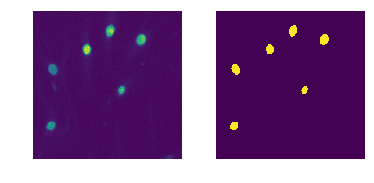

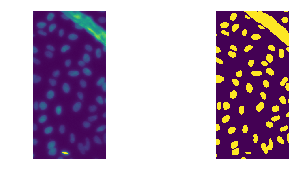

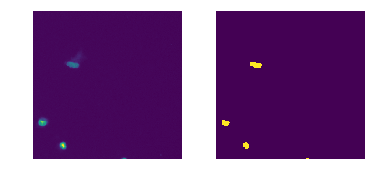

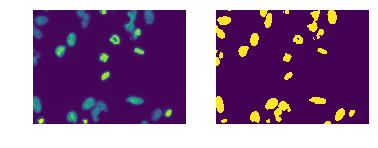

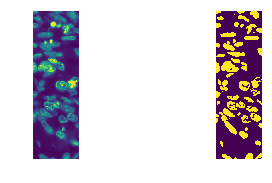

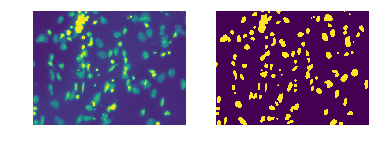

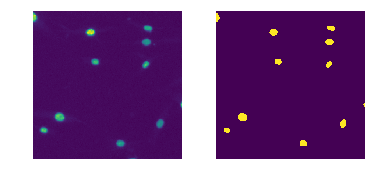

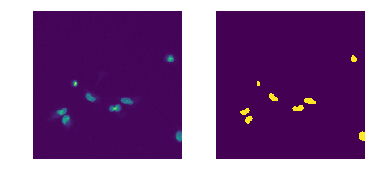

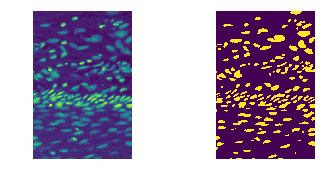

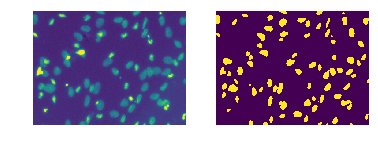

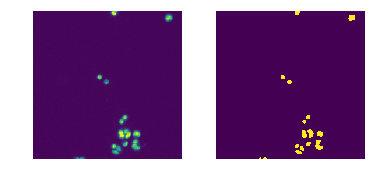

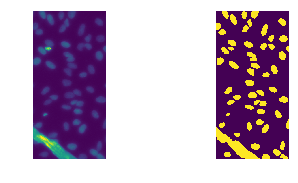

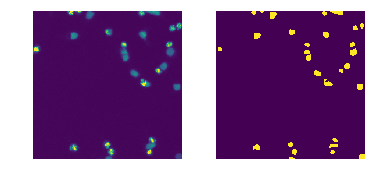

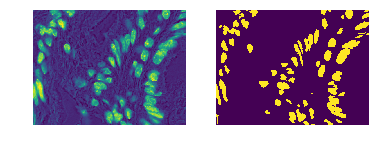

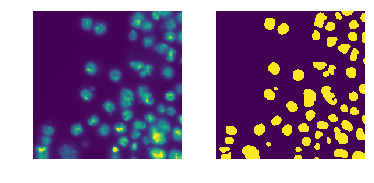

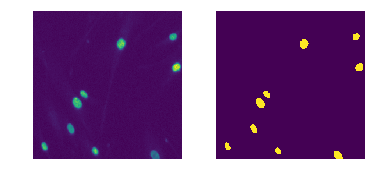

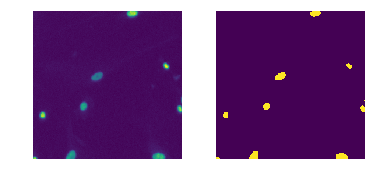

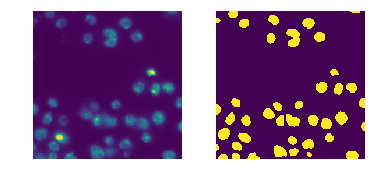

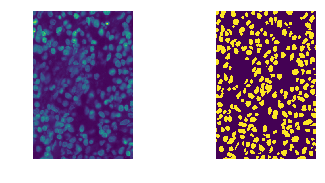

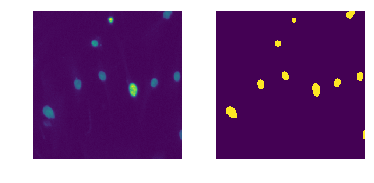

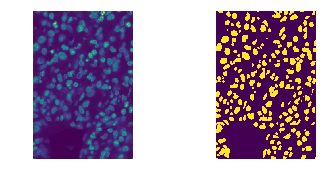

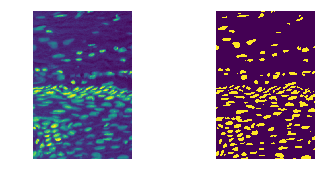

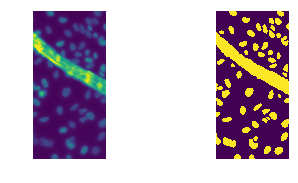

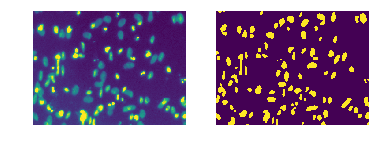

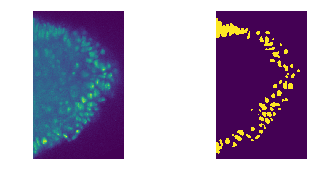

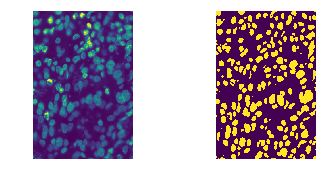

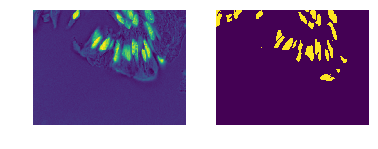

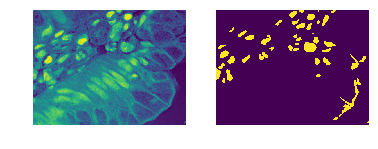

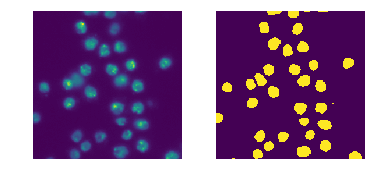

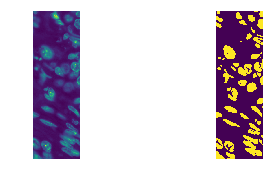

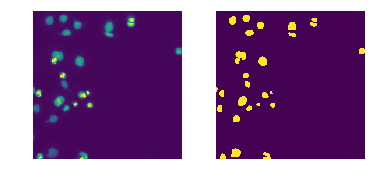

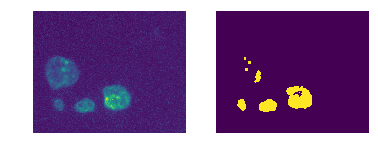

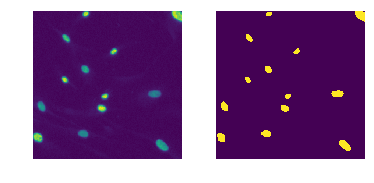

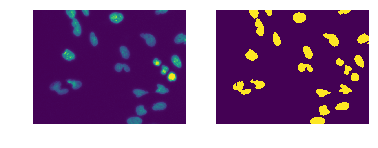

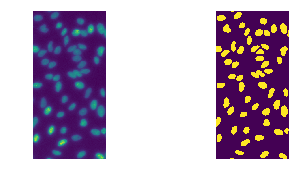

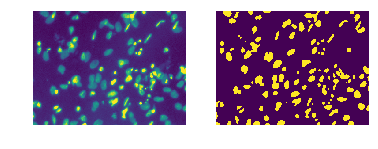

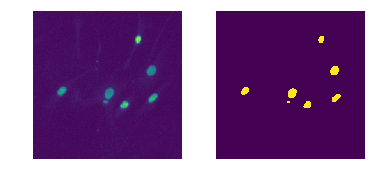

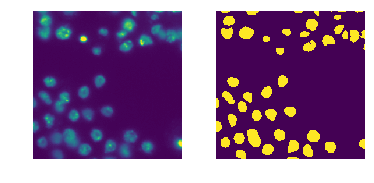

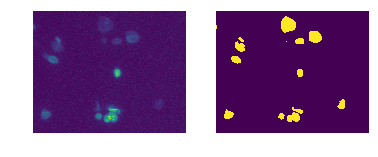

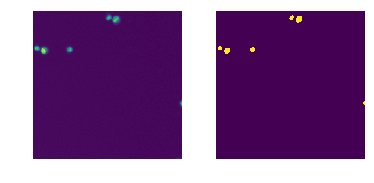

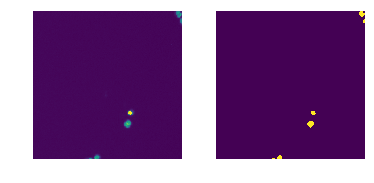

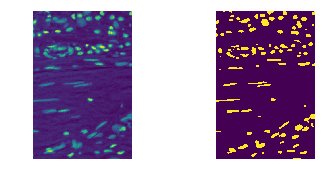

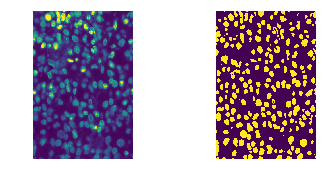

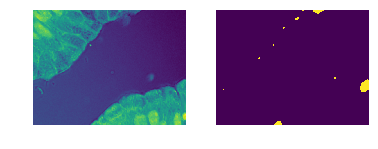

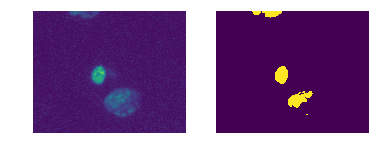

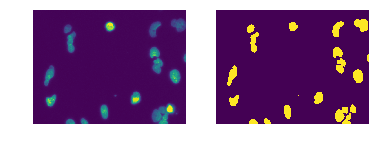

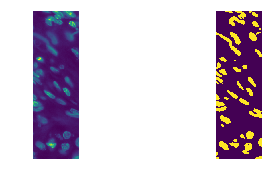

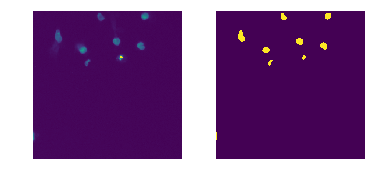

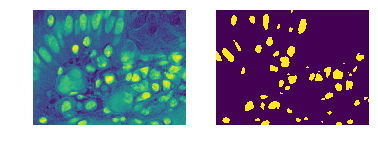

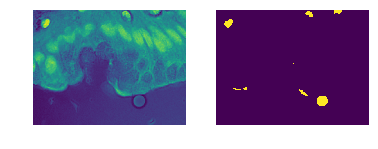

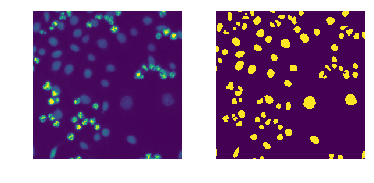

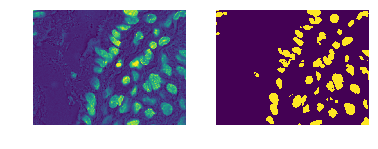

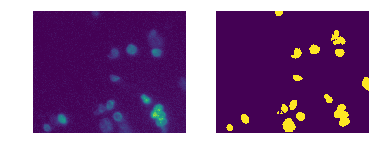

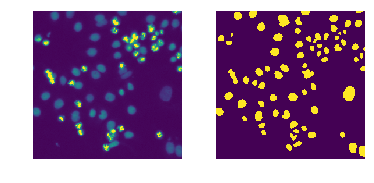

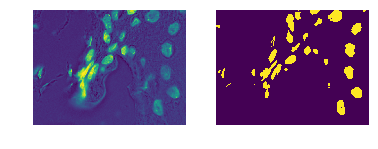

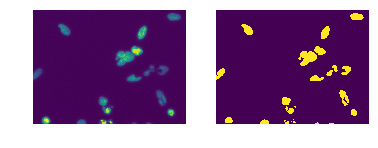

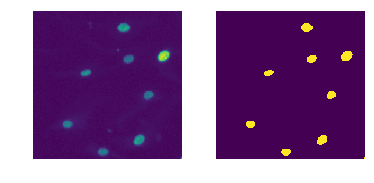

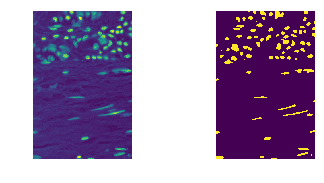

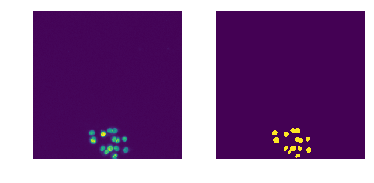

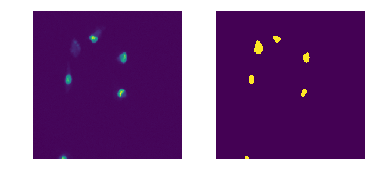

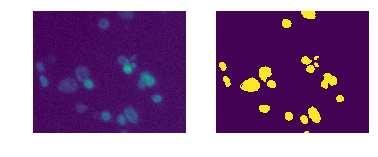

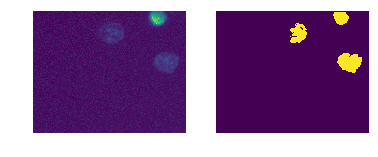

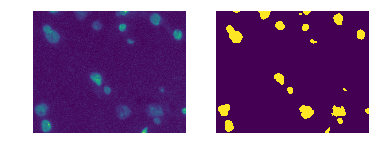

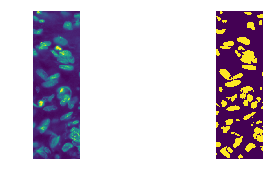

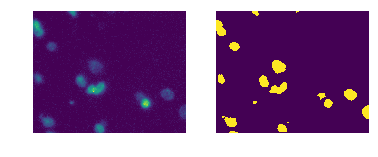

In [57]:
for img, p in zip(test, preds_test_upsampled):
    plt.figure(figsize=(6, 6))
    plt.subplot(221)
    plt.imshow(np.squeeze(img))
    plt.axis('off')
    plt.subplot(222)
    plt.imshow(np.squeeze(p) > .9)
    plt.axis('off')
    plt.show()


In [30]:
for path, pred in zip(test_paths, preds_test_upsampled):
    np.save(os.path.join(path, 'borders_mask_elu16_bce1dice_soft_merging_LB_34_zoom_x_1.3'), pred)

In [51]:
new_test_ids = []
rles = []
for n, path in tqdm(enumerate(test_paths)):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([os.path.basename(path)] * len(rle))


65it [00:01, 54.84it/s]


In [52]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('../data/dsb18.csv', index=False)